In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import h5py
import json
import matplotlib.pyplot as plt
import sparse
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import nn, Tensor
import numpy as np
from typing import *
from pathlib import Path
import math

In [2]:
from metric import compute_improvement

In [3]:
PATH = Path("/home/centos/mount_point/data/cmu_challenge/")

## Neural Network with low level features

In [4]:
class MuonData(Dataset):
    def __init__(self, file_name):
        self.file_name = file_name
        self.open_file()
        
    def __len__(self) -> int:
        return self.len
    
    def __del__(self) -> None:
        if hasattr(self, 'hits'): del self.hits
        if hasattr(self, 'file'): self.file.close()
            
    def open_file(self) -> None:
        self.file = h5py.File(self.file_name, "r")
        self.shape = json.loads(self.file['meta_data/matrix_feats'][()])['shape']
        all_hits = self.file['fold_0/matrix_inputs']
        coords = all_hits[1:].astype(int)
        self.hits = sparse.COO(coords=coords, data=all_hits[0], shape=[coords[0][-1]+1]+self.shape)
        self.hl_inputs = self.file['fold_0/inputs'][()]
        self.targets = self.file['fold_0/targets'][()]
        self.len = len(self.file['fold_0/targets'])
    
    def __getitem__(self, idx) -> Tuple[np.ndarray, np.ndarray, float]: 
        if not hasattr(self, 'file'): self.open_file()
        return self.hl_inputs[idx], self.hits[idx].todense(), self.targets[idx]

%%time
_ = training_data[0]

In [5]:
class cnn3d(nn.Module):
    def __init__(self, n_layers_per_res:int=1, channel_coef:float=1.5, device:Optional[torch.device]=None):
        super().__init__()
        if device is None: device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        self.device = device
        self.conv_layers = self._build_conv_layers(n_layers_per_res, channel_coef).to(self.device)
        self.n_conv_out = self._compute_conv_out()
        self.fc_layers = self._build_fc_layers().to(self.device)

    def flatten_x(self, x:Tensor) -> Tensor:
        return x.view(x.size(0),-1)  # flatten tensor to (N, M), could be replaced by a pooling layer

    def _compute_conv_out(self) -> int:
        with torch.no_grad():
            self.conv_layers.eval()
            x = torch.zeros((1,1,50,32,32), device=self.device)
            x = self.conv_layers(x)
            x = self.flatten_x(x)
        self.conv_layers.train()
        return x.shape[1]  # number of features per muon

    def _build_conv_layers(self, n_layers_per_res:int, channel_coef:float) -> nn.Sequential:
        layers = []
        n_in = 1
        kernel_sz = 3

        for i in range(4):
            for j in range(n_layers_per_res):
                if j == 0:
                    # Downsample
                    stride = 2
                    if i == 0:
                        n_out = 8  #  large upscale on first downsample
                    else:
                        n_out = int(n_in*channel_coef)
                else:
                    stride = 1
                    n_out = n_in
                layers.append(self._get_conv_layer(n_in=n_in, n_out=n_out, kernel_sz=kernel_sz, stride=stride))
                n_in = n_out
        return nn.Sequential(*layers)
    
    def _get_conv_layer(self, n_in:int, n_out:int, kernel_sz:Union[int,Tuple[int,int,int]],
                        stride:int=1, padding:Union[str,int,Tuple[int,int,int]]='auto') -> nn.Sequential:
        layers = []
        
        if padding == 'auto': padding = kernel_sz//2 if isinstance(kernel_sz, int) else [i//2 for i in kernel_sz]
        layers.append(nn.Conv3d(in_channels=n_in, out_channels=n_out, kernel_size=kernel_sz,
                                padding=padding, stride=stride, bias=False))
        nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu', a=0)
        layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def _get_fc_layer(self, n_in:int, n_out:int, act:bool=True) -> nn.Sequential:
        layers = []
        layers.append(nn.Linear(n_in, n_out))
        nn.init.kaiming_normal_(layers[-1].weight, nonlinearity='relu', a=0)
        nn.init.zeros_(layers[-1].bias)
        if act: layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def _build_fc_layers(self) -> nn.Sequential:
        layers = []
        n_in = self.n_conv_out
        for i in range(2):
            n_out = np.max((1,n_in//2))
            layers.append(self._get_fc_layer(n_in, n_out))
            n_in = n_out
        layers.append(self._get_fc_layer(n_in=n_in, n_out=1, act=False))  # Final layer single output, linear activation
        return nn.Sequential(*layers)

    def forward(self, x:Tensor) -> Tensor:
        x = self.conv_layers(x)
        x = self.flatten_x(x)
        x = self.fc_layers(x)
        return x

In [6]:
net = cnn3d()

In [7]:
net

cnn3d(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv3d(8, 12, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv3d(12, 18, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
    (3): Sequential(
      (0): Conv3d(18, 27, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      (1): ReLU()
    )
  )
  (fc_layers): Sequential(
    (0): Sequential(
      (0): Linear(in_features=432, out_features=216, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=216, out_features=108, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=108, out_features=1, bias=True)
    )
  )
)

%%time
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True)
for i, b in enumerate(train_dataloader):
    net(b[1].to(net.device))
    if i == 10: break

%%time
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=2)
for i, b in enumerate(train_dataloader):
    net(b[1].to(net.device))
    if i == 10: break

%%time
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=4)
for i, b in enumerate(train_dataloader):
    net(b[1].to(net.device))
    if i == 10: break

## Training loop

In [8]:
loss_fn = nn.MSELoss()

In [9]:
optimizer = torch.optim.Adam(net.parameters())

In [10]:
training_data = MuonData(PATH/'muon_calo_train.hdf5')

In [11]:
val_data = MuonData(PATH/'muon_calo_val.hdf5')

In [12]:
train_dataloader = DataLoader(training_data, batch_size=256, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_data, batch_size=1000, shuffle=False, num_workers=4)

In [13]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (hl_feats, hits, labels) in enumerate(dataloader):
        
        hits, labels = hits.to(net.device), labels.to(net.device)
        labels = labels.unsqueeze(1)
        # Compute prediction and loss
        pred = model(hits)
        loss = loss_fn(pred, labels)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(hits)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [21]:
def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for hl_feats, hits, labels in dataloader:
            hits, labels = hits.to(net.device), labels.to(net.device)
            labels = labels.unsqueeze(1)
            pred = model(hits)
            test_loss += loss_fn(pred,labels).data.item()

    test_loss /= num_batches
    print("Test Error:", test_loss)
    return test_loss

In [22]:
def save_best_model(net:nn.Module, save_path:Path) -> None:
    save_path.mkdir(parents=True, exist_ok=True)
    torch.save({'model':net.state_dict()}, str(save_path/'best.pt'))

In [23]:
def load_best_model(net:nn.Module, load_path:Path) -> None:
    state = torch.load(str(load_path/'best.pt'), map_location=net.device.type)
    net.load_state_dict(state['model'])

In [24]:
%%time
epochs = 3
lowest_loss = math.inf
save_path = Path('weights')
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, net, loss_fn, optimizer)
    loss = test_loop(val_dataloader, net, loss_fn)
    if loss < lowest_loss:
        save_best_model(net, save_path)
        lowest_loss = loss
print("Done!")

Epoch 1
-------------------------------
loss: 3491600.250000  [    0/88675]
loss: 2692206.000000  [25600/88675]
loss: 2724675.500000  [51200/88675]
loss: 2936344.500000  [76800/88675]
Test Error: 3144557.8981481483
Epoch 2
-------------------------------
loss: 3034490.250000  [    0/88675]
loss: 2688996.500000  [25600/88675]
loss: 3238533.500000  [51200/88675]
loss: 2496553.500000  [76800/88675]
Test Error: 3134506.861111111
Epoch 3
-------------------------------
loss: 2875173.750000  [    0/88675]
loss: 3146677.750000  [25600/88675]
loss: 3139874.000000  [51200/88675]
loss: 3466814.750000  [76800/88675]
Test Error: 3063475.6481481483
Done!
CPU times: user 34 s, sys: 36.2 s, total: 1min 10s
Wall time: 1min 15s


In [25]:
load_best_model(net, save_path)

## Validation

In [26]:
def create_submission(dataloader, model):
        
    predictions = []
    targets = []
    model.eval()
    with torch.no_grad():
        for hl_feats, hits, labels in dataloader:
            hits = hits.to(net.device)
            predictions.append(model(hits).cpu().detach().numpy())
            targets.append(labels)
    predictions = np.concatenate(predictions, axis=0)
    targets = np.concatenate(targets, axis=0)
    return predictions, targets

In [27]:
preds, targs = create_submission(val_dataloader, net)

In [28]:
df = pd.DataFrame({'pred': preds.squeeze(), 'target': targs})

In [29]:
df.head()

,pred,target
0,4908.295410,5709.742676
1,4323.287598,5540.189453
2,6110.408691,2945.265869
3,4181.826172,5475.326660
4,6214.262207,7548.465332


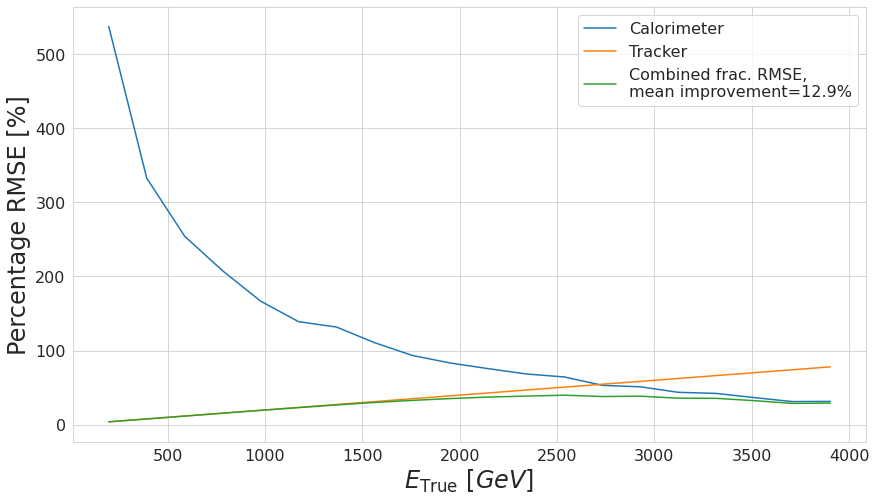

0.12933833871657768

In [30]:
compute_improvement(df)

## Submission

In [ ]:
del training_data, train_dataloader, val_data, val_dataloader

In [37]:
sub_data = MuonData(PATH/'muon_calo_test.hdf5')

In [38]:
sub_dataloader = DataLoader(sub_data, batch_size=1000, shuffle=False, num_workers=4)

In [39]:
preds,_ = create_submission(sub_dataloader, net)

deleted
deleted
deleteddeleted



In [40]:
df = pd.DataFrame(preds, columns=["prediction"])

In [41]:
df.head()

,prediction
0,1281.522217
1,5418.889160
2,6039.638184
3,5037.421875
4,2838.672363


In [42]:
df.to_csv("test.csv")

In [43]:
del sub_data, sub_dataloader

deleted
